#### **Installs**

In [1]:
#!git clone https://github.com/WongKinYiu/yolov7.git
#!pip install -r /content/yolov7/requirements.txt
#!pip install -r yolov7/requirements.txt
#!pip install nibabel

Cloning into 'yolov7'...
remote: Enumerating objects: 1169, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 1169 (delta 16), reused 18 (delta 9), pack-reused 1139
Receiving objects: 100% (1169/1169), 70.42 MiB | 17.87 MiB/s, done.
Resolving deltas: 100% (504/504), done.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: '/content/yolov7/requirements.txt'

[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [10]:
#!wget https://msd-for-monai.s3-us-west-2.amazonaws.com/Task03_Liver.tar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 49.5 MB/s eta 0:00:00:00:01

[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


#### **Imports**

In [1]:
import tarfile
import random
import shutil
import json
import os

import cv2

import nibabel as nib

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from skimage.transform import rotate

import imageio

from IPython.display import display, Image

import PIL
from PIL import ImageDraw

import xml.etree.ElementTree as ET
from xml.dom import minidom

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

#from google.colab import drive
#drive.mount("/content/drive/")

#### **Read Data**

In [2]:
#data_dir = '/content/drive/MyDrive/תואר שני/שנה ב/סמסטר ב/AI for Healthcare/Assignments/Assignment 2/MSD/Task03_Liver.tar'
data_dir = 'Task03_Liver.tar'

# Open, unzips and decompresses the dataset
#tar = tarfile.open(data_dir, "r:*")  
#tar.extractall()
#tar.close()

# Read dataset.json
jsn = json.load(open('Task03_Liver/dataset.json'))

# Split the training set into train and test sets 
X = [image['image'].replace("./", "Task03_Liver/") for image in jsn['training']]
y = [image['label'].replace("./", "Task03_Liver/") for image in jsn['training']]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#### **EDA**

**Util functions**

In [3]:
def get_image_data(img_file):
    img = nib.load(img_file) # Load the nii.gz file
    return img.get_fdata().astype('uint8')   # Get the image data

# Rotate the image, angle_range=(tuple)
def random_rotation(image, angle_range):
    angle = np.random.uniform(*angle_range)
    return rotate(image, angle, mode='reflect')

def get_bounding_box(label):
    # Convert to binary mask
    binary_mask = label.astype(np.uint8).copy() 
    binary_mask[binary_mask<2]  = 0
    binary_mask[binary_mask==2] = 1

    if binary_mask.max() == 0:
        return [(0, 0), (0, 0)]

    # Find contours of segmented objects
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detection_dataset = []

    for contour in contours:
        # Find the bounding box coordinates
        x_top_l, y_top_l, width, height = cv2.boundingRect(contour)

        image_height, image_width, _ = binary_mask.shape

        # Calculate bottom right point
        x_borrom_r = x_top_l + width
        y_borrom_r = y_top_l + height

        # Calculate the middl point of the object
        x_mid = int((x_top_l + x_borrom_r) / 2)
        y_mid = int((y_top_l + y_borrom_r) / 2)

        # Normalizing the data to the image shape
        x_mid_normalized  = round(x_mid  / image_width, 6)
        y_mid_normalized  = round(y_mid  / image_height, 6)
        height_normalized = round(height / image_height, 6)
        width_normalized  = round(width  / image_width, 6)
        
        detection_dataset.append([x_mid_normalized, y_mid_normalized, height_normalized, width_normalized])

    return detection_dataset

# Translate the image, shift_range=(tuple)
def random_translation(image, shift_range):
    h, w = image.shape[:2]
    x_shift, y_shift = np.random.uniform(*shift_range, size=2)
    x_shift = int(x_shift * w)
    y_shift = int(y_shift * h)
    translation_matrix = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
    return cv2.warpAffine(image, translation_matrix, (w, h))

def transform_image(image_data):
    if random.random() < 0.5:
        image_data = random_rotation(image_data, (-90, 90))
    else:
        image_data = random_translation(image_data, (-0.1, 0.1))

    return image_data

def display_image(img_file, label_file, index):
    # Plot one 2D image
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot original image
    data = get_image_data(img_file)

    axs[0].imshow(data[:,:, index], cmap='gray')
    axs[0].axis('off')
    axs[0].set_title('Original image')

    # Plot image label
    data = get_image_data(label_file)

    axs[1].imshow(data[:,:, index], cmap='gray')
    axs[1].axis('off')
    axs[1].set_title('Labeled image')

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.2)

    # Display the figure
    plt.show()

In [12]:
asd = get_image_data(y[4])
for i in range(asd.shape[2]):
    if asd[:,:,i].max() == 2:
        print(i)
        break

396


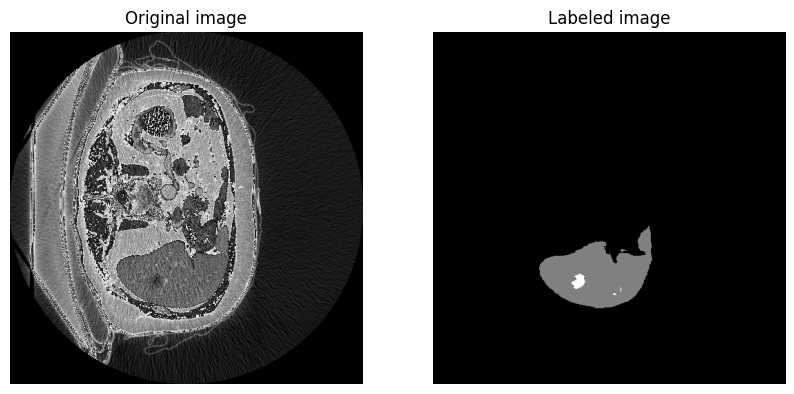

In [18]:
display_image(X[4], y[4], 430)

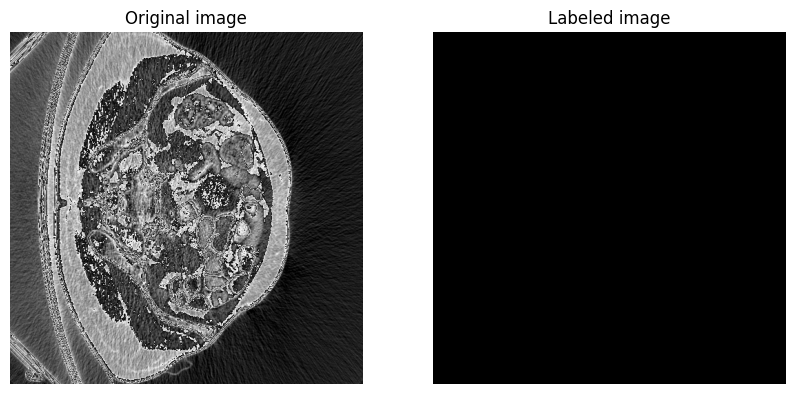

In [16]:
display_image(X[0], y[0], 152)

#### **Data preprocessing**

In [19]:
# https://blog.paperspace.com/train-yolov7-custom-data/
def get_training_item(image_name, label_name, labeled_only=True):
    # Read the data
    image = get_image_data(image_name)
    label = get_image_data(label_name)

    # Find the indices of channels where the maximum label value is 2
    indices = np.where(label.max(axis=(0, 1)) == 2)[0]

    # Extract the labeled image and label channels based on the indices
    image = image[..., indices]
    label = label[..., indices]

    labeled_bb = [];
    for i in range(label.shape[2]):
        labeled_bb.append(get_bounding_box(np.expand_dims(label[:,:,i],-1)))
        
    return image, label, labeled_bb



def save_image_to_disk_train(image, label, idx):
    # Make a directory for the images and annotations
    !mkdir images_train annotations


    for i in range(image.shape[2]):
        file_name = f'image_{idx}_{i}'
        imageio.imsave(f"images_train/{file_name}.png", image[:,:,i])
        
        text = ''
        for bb_idx in range(len(label[i])):
            # Unpack the bounding box data
            x_mid_normalized, y_mid_normalized, height_normalized, width_normalized = label[i][bb_idx]
            text += f'0 {x_mid_normalized} {y_mid_normalized} {width_normalized} {height_normalized}\n'

        if text != '':
            # Save txt file
            with open(f"annotations/{file_name}.txt", 'a') as file:
                file.write(text[:-1]) # Remove last NewLine

def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)

def rearange_data():
    # Read images and annotations
    images = [os.path.join('images_train', x) for x in os.listdir('images_train')]
    annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

    images.sort()
    annotations.sort()

    # Split the dataset into train-valid-test splits 
    train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
    val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

    # Create folders
    !mkdir images labels images/train images/val images/test labels/train labels/val labels/test

    # Move the splits into their folders
    move_files_to_folder(train_images, 'images/train')
    move_files_to_folder(val_images, 'images/val/')
    move_files_to_folder(test_images, 'images/test/')
    move_files_to_folder(train_annotations, 'labels/train/')
    move_files_to_folder(val_annotations, 'labels/val/')
    move_files_to_folder(test_annotations, 'labels/test/')
    !mv annotations labels

In [6]:
#for i in range(len(X)):
#    X_current, y_current, bb_current = get_training_item(X[i], y[i])
#    save_image_to_disk_train(X_current, bb_current, i)
#rearange_data()

#### **Train the model**

In [ ]:
#train_cfg = '/content/yolov7/cfg/training/yolov7-tiny.yaml'
train_cfg = 'yolov7/cfg/training/yolov7-tiny.yaml'
#hyper_parameters = '/content/yolov7/data/hyp.scratch.tiny.yaml'
hyper_parameters = 'yolov7/data/hyp.scratch.tiny.yaml'
#liver_cancer = '/content/yolov7/data/liver_cancer.yaml'
liver_cancer = 'yolov7/data/liver_cancer.yaml'
#/content/
'''
train: MSD Dataset/images/test/
val: MSD Dataset/images/val/
test: MSD Dataset/images/train/

# number of classes
nc: 1

# class names
names: ['Liver Cancer']
'''

"\ntrain: /content/images/test/\nval: /content/images/val/\ntest: /content/images/train/\n\n# number of classes\nnc: 1\n\n# class names\nnames: ['Liver Cancer']\n"

In [7]:
#/content/yolov7/train.py
!python yolov7/train.py \
                 --img-size 512 \
                 --cfg yolov7/cfg/training/yolov7-tiny.yaml \
                 --hyp yolov7/data/hyp.scratch.tiny.yaml \
                 --batch 8 \
                 --epochs 100 \
                 --data yolov7/data/liver_cancer.yaml \
                 --weights ' ' \
                 --workers 24 \
                 --name yolo_liver_cancer

2023-05-29 10:23:38.760051: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 10:23:48.600656: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /anaconda/envs/py38_default/lib/python3.8/site-packages/cv2/../../lib64:/opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/
2023-05-29 10:23:48.600902: W tensorflow/c

#### **Test model**

In [10]:
!python yolov7/detect.py \
        --source 'MSD Dataset/images/test/' \
        --weights runs/train/yolo_liver_cancer10/weights/best.pt \
        --conf 0.25 \
        --name yolo_liver_cancer

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='yolo_liver_cancer', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='MSD Dataset/images/test/', update=False, view_img=False, weights=['runs/train/yolo_liver_cancer10/weights/best.pt'])
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0 CPU

Fusing layers... 
IDetect.fuse
/anaconda/envs/py38_default/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402316912/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 208 layers, 6007596 parameters, 0 gradients, 13.0 GFLOPS
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

Done. (120.3ms) Inference,